# Unsupervised Learning

# Introduction and Dataset

## Background

Landcover classification is a common method in remote sensing that uses satellite or aerial imagery to categorize to composition of the landscape. Landcover classification is especially important in the field of forestry to identify forested vs. non-forested areas, in addition to different forest types (e.g., coniferous vs. deciduous).

One approach to landcover classification is through supervised machine learning, such as random forest or support vector machines. However, this approach requires representative sample data to train an effective model. Moreover, this approach requires prior knowledge about the landscape in question in addition to how many unique landcover classes should be used.

Unsupervised learning on the other hand is effective for landcover classification because it does not require any training samples nor does it require a prior understanding of the landscape composition. As such, this makes unsupervised classification an effective initial, exploratory approach for landcover classification.

In this tutorial, we use k-means unsupervised learning to perform landcover classification in the Petawawa research forest (PRF) following similar methods to Burrough et. al (2001).

## Tutorial goals

**Goal 1: Apply K-means clustering to perform landcover classification using Sentinel-2 imagery over the PRF.**

**Goal 2: Investigate the composition of the clusters**

**Goal 3: Apply the K-means clustering to the entire PRF**

## Data

This tutorial makes use of Sentinel-2 multispectral imagery. See the README or website for more information about the Sentinel-2 dataset.

## References

Burrough, Peter A., et al. "Fuzzy k-means classification of topo-climatic data as an aid to forest mapping in the Greater Yellowstone Area, USA." Landscape ecology 16.6 (2001): 523-546.

In [1]:
import rioxarray as rio
import numpy as np
from rasterio.plot import show
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from matplotlib import colormaps

In [2]:
# Load data

s2_2018_fpath = 'data/petawawa_s2_2018.tif'

boundary_fpath = 'data/boundary.gpkg'

s2_2018 = rio.open_rasterio(s2_2018_fpath)

boundary_gdf = gpd.read_file(boundary_fpath).to_crs(s2_2018.rio.crs)

# Check the shape of the raster values
s2_2018.values.shape

(12, 937, 1824)

# Visualize the PRF Sentinel-2 imagery again

In [3]:
# Define function to get simplified matplotlib output

def simplify_plt(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

<Axes: >

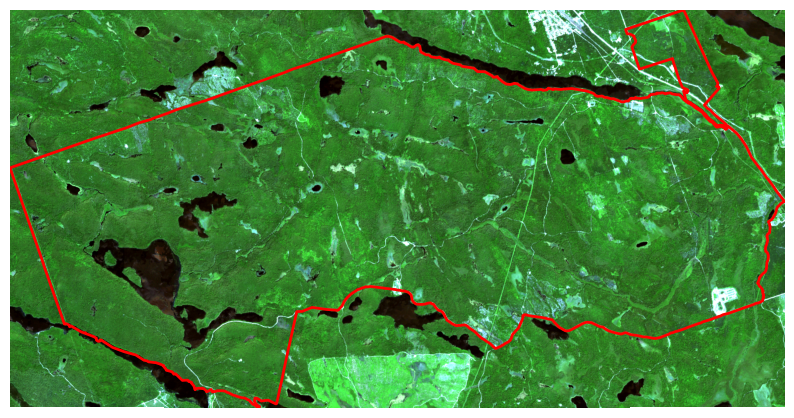

In [4]:
# Perform a percentage clip to remove very bright/dark pixels and enhance image contrast

def plot_rgb(rgb, ax, low_perc=1, high_perc=99):

    #find the values to do contrast stretching
    vmin, vmax = np.nanpercentile(rgb, (low_perc, high_perc))

    #ensure values are between 0 and 1
    rgb = np.clip(rgb, vmin, vmax)

    # Visualize the PRF Sentinel-2 imagery
    show(rgb, ax=ax, transform=s2_2018.rio.transform(), adjust=True)


fig, ax = plt.subplots(figsize=(10, 10))

plot_rgb(s2_2018.values[1:4], ax=ax)

simplify_plt(ax)

boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Collect Samples of Image Pixels

In order to perform k-means clustering, we need to sample the image. We could theoretically use all the image pixels, but this would be too computationally demanding and likely redundant.

In [5]:
# Check how many pixels are in the image
n_pixels = s2_2018.shape[1] * s2_2018.shape[2]

print(f'There are {n_pixels} in the image.')

There are 1709088 in the image.


To save time and compute, we can sample the image along an evenly spaced grid.

 n = 2491 samples within the boundary.


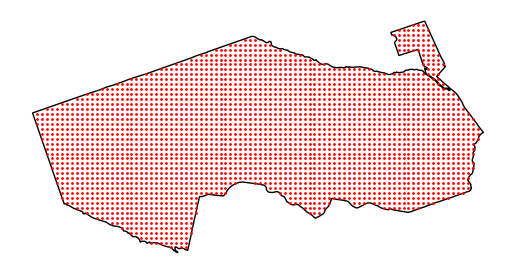

In [6]:
# We want to classify all the pixels in the image, to do so we will start with a sample  of points

# We will sample points on a grid with points spaced 300 meters apart

spacing = 200

xmin, ymin, xmax, ymax = boundary_gdf.total_bounds

xcoords = [i for i in np.arange(xmin, xmax, spacing)]
ycoords = [i for i in np.arange(ymin, ymax, spacing)]

pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2) #A 2D array like [[x1,y1], [x1,y2], ...
sample_pts = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
sample_pts = gpd.GeoSeries(sample_pts, crs=boundary_gdf.crs)

sample_pts.name = 'geometry'

sample_pts = gpd.sjoin(gpd.GeoDataFrame(sample_pts), boundary_gdf[['geometry']], how="inner", predicate='within')

ax = boundary_gdf.plot(color='none', edgecolor='black')

sample_pts.plot(ax=ax, color='red', markersize=1)

simplify_plt(ax)

print(" n =", len(sample_pts), "samples within the boundary.")

# Extract pixel values from samples

In [7]:
# Extract pixel values for each band at the sample points

plot_coords = [(geom.x, geom.y) for geom in sample_pts.geometry]

sample_pixels_ls = [s2_2018.sel(x=c[0], y=c[1], method="nearest").values for c in plot_coords]

sample_pixels_arr = np.stack(sample_pixels_ls, axis=0)


samples_df = pd.DataFrame(sample_pixels_arr,
             columns=['Aerosols', 'Blue', 'Green', 'Red', 
                      'Red Edge 1', 'Red Edge 2', 'Red Edge 3', 
                      'NIR', 'Red Edge 4', 'Water vapor', 
                      'SWIR 1', 'SWIR 2'])
samples_df


,Aerosols,Blue,Green,Red,Red Edge 1,Red Edge 2,Red Edge 3,NIR,Red Edge 4,Water vapor,SWIR 1,SWIR 2
0,0.01505,0.02300,0.04800,0.01855,0.08155,0.32965,0.41315,0.40715,0.43460,0.37585,0.17235,0.07385
1,0.01250,0.01710,0.02980,0.01330,0.05425,0.20595,0.27335,0.27255,0.28695,0.35720,0.12945,0.05805
2,0.01405,0.01930,0.03420,0.01810,0.05875,0.20195,0.25340,0.26020,0.27805,0.32235,0.13330,0.06000
3,0.01400,0.02510,0.05825,0.02455,0.08955,0.33650,0.42485,0.47235,0.46075,0.41050,0.18310,0.08050
4,0.01325,0.01560,0.03225,0.01240,0.06875,0.25960,0.33925,0.31620,0.35280,0.37420,0.14335,0.06010
...,...,...,...,...,...,...,...,...,...,...,...,...
2486,0.01930,0.03255,0.05760,0.03365,0.08995,0.28525,0.35275,0.35565,0.38745,0.38660,0.16980,0.08015
2487,0.03490,0.06830,0.08780,0.08810,0.11805,0.26695,0.31635,0.27570,0.33510,0.34555,0.19275,0.13115
2488,0.01850,0.02310,0.04310,0.02115,0.06450,0.21775,0.28495,0.35025,0.30685,0.28200,0.12750,0.05980
2489,0.01885,0.02075,0.03705,0.01940,0.06795,0.23755,0.28725,0.33725,0.31320,0.34585,0.13735,0.06360


# Perform K-Means clustering

Run the code below to perform the k-means clustering. Experiment with the number of clusters (i.e., landcover classes).

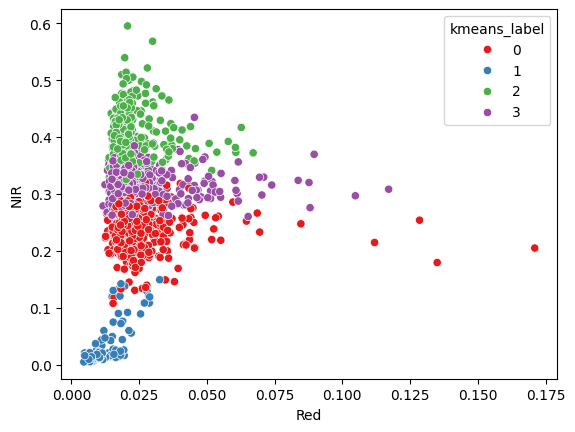

In [8]:
N_CLUSTERS = 4

# Perform k-means clustering on the sample points

kmeans = KMeans(n_clusters=N_CLUSTERS, # Set the number of clusters
                random_state=0).fit(samples_df) # Set the random seed for reproducibility

samples_df['kmeans_label'] = kmeans.labels_

clust_centers = kmeans.cluster_centers_

# Plot Red and NIR bands against each other with cluster centers shown
ax = sns.scatterplot(data=samples_df, 
                x='Red', 
                y='NIR', 
                hue='kmeans_label', 
                palette='Set1')


# Classify the entire Sentinel-2 image using the k-means clusters

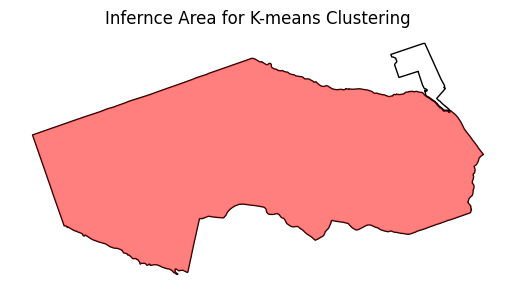

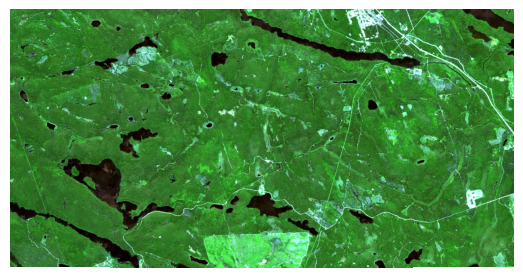

In [9]:

inference_area = boundary_gdf.iloc[1:]

# View subset window 

ax = boundary_gdf.plot(color='none', edgecolor='black')
inference_area.plot(ax=ax, color='red', alpha=0.5)
ax.set_title('Infernce Area for K-means Clustering')

simplify_plt(ax)

plt.show()

# Clip sentinel-2 imagery to test area and view
s2_2018_subset = s2_2018.rio.clip(inference_area.geometry, inference_area.crs)

fig, ax = plt.subplots(figsize=(6.5, 6.5))

plot_rgb(s2_2018.values[1:4], ax=ax)

simplify_plt(ax)

plt.show()

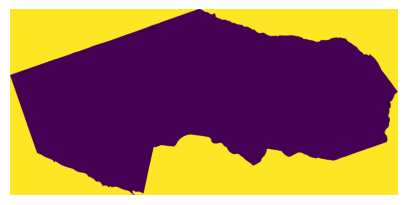

In [10]:
# Check for NAs in the raster
nan_count_mask = np.isnan(s2_2018_subset.values).sum(axis=0)

fig, ax = plt.subplots(figsize=(5, 5))
show(nan_count_mask, ax=ax)
simplify_plt(ax)

# Replace NAs with zeroes
s2_2018_subset = s2_2018_subset.fillna(0)

In [11]:

n_bands = s2_2018_subset.shape[0]

pixels = s2_2018_subset.values.reshape(n_bands, -1).T

s2_2018_subset_df = (pd.DataFrame(pixels, 
                                 columns=samples_df.columns.tolist()[:-1])
                                 )



s2_2018_subset_df

,Aerosols,Blue,Green,Red,Red Edge 1,Red Edge 2,Red Edge 3,NIR,Red Edge 4,Water vapor,SWIR 1,SWIR 2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1591474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Apply k-means clustering to the test area

pred = kmeans.predict(s2_2018_subset_df)

pred = pred.reshape(s2_2018_subset.shape[1:3])

pred.shape

(873, 1823)

In [13]:
# Clip raster to study area

assert s2_2018_subset.values.shape[1:3] == pred.shape, "Shape mismatch between raster and prediction array."

# Assing kmeans labels to the first s2 raster band, then drop all other bands
# This will create a new raster where each pixel is assigned a cluster label

kmeans_ras = s2_2018_subset.copy(deep=True)

kmeans_ras.values[0, :, :] = pred

kmeans_ras = kmeans_ras.sel(band=1)

kmeans_ras.attrs["long_name"] = "kmeans_label"

# Finally, clip kmeans ras to the target area
kmeans_ras = kmeans_ras.rio.clip(inference_area.geometry, inference_area.crs)

kmeans_ras

<xarray.DataArray (y: 873, x: 1823)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(873, 1823), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 15kB 2.973e+05 2.973e+05 ... 3.155e+05 3.155e+05
  * y            (y) float64 7kB 5.098e+06 5.098e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      kmeans_label

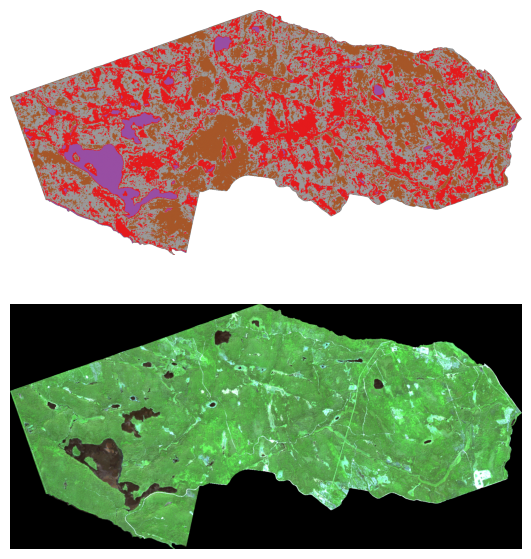

In [15]:
# Plot pred area and RGB image side by side

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))

im = ax1.imshow(kmeans_ras.values, cmap='Set1')

plot_rgb(s2_2018_subset.values[1:4], ax=ax2)

simplify_plt(ax1)

simplify_plt(ax2)